**<h2>Introduction**

In this notebook, I try to explore the TGS Salt Segmentation data. My purpose here is not to set up a segmentation model, but rather to try to explore the provided data and get some sense of what types of features may be useful. I hope you find this helpful. Happy Kaggling :-)

In [ ]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.feature import canny
from skimage.filters import sobel,threshold_otsu, threshold_niblack,threshold_sauvola
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from scipy import signal

import cv2
from PIL import Image
import pdb
from tqdm import tqdm
import seaborn as sns
import os 
from glob import glob

import warnings
warnings.filterwarnings("ignore")

<h2> Setting the Paths

In [ ]:
INPUT_PATH = '../input'
DATA_PATH = INPUT_PATH
TRAIN_DATA = os.path.join(DATA_PATH, "train/images")
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, "train/masks")
TEST_DATA = os.path.join(DATA_PATH, "test")
df = pd.read_csv(DATA_PATH+'/depths.csv')
path_train = '../input/train/'
path_test = '../input/test/'
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

<h2> Some utility functions

In [ ]:
def get_filename(image_id, image_type):
    check_dir = False
    if "Train" == image_type:
        data_path = TRAIN_DATA
    elif "mask" in image_type:
        data_path = TRAIN_MASKS_DATA
    elif "Test" in image_type:
        data_path = TEST_DATA
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}".format(image_id))

def get_image_data(image_id, image_type, **kwargs):
    img = _get_image_data_opencv(image_id, image_type, **kwargs)
    img = img.astype('uint8')
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

<h2>**Plotting Images**

Lets plot some random images from training set and some images with the mask overlayed on top of it.

In [ ]:
nImg = 32  #no. of images that you want to display
np.random.seed(42)
_train_ids = list(train_ids)
np.random.shuffle(_train_ids)
_train_ids = _train_ids[:nImg]
tile_size = (256, 256)
n = 8
alpha = 0.25

m = int(np.ceil(len(_train_ids) * 1.0 / n))
complete_image = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)
complete_image_masked = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i*(tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j*(tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids):
            break
        image_id = _train_ids[counter]; counter+=1
        img = get_image_data(image_id, 'Train')
        
        mask = get_image_data(image_id, "Train_mask")
        img_masked =  cv2.addWeighted(img, alpha, mask, 1 - alpha,0)
#         img_masked = cv2.bitwise_and(img, img, mask=mask)

        img = cv2.resize(img, dsize=tile_size)
        img_masked = cv2.resize(img_masked, dsize=tile_size)
        
        img = cv2.putText(img, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), thickness=2)
        complete_image[ys:ye, xs:xe, :] = img[:,:,:]
        
        img_masked = cv2.putText(img_masked, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), thickness=2)
        complete_image_masked[ys:ye, xs:xe, :] = img_masked[:,:,:]
        
    if counter == len(_train_ids):
        break    
        
m = complete_image.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image[ys:ye,:,:])
    plt.title("Training dataset")
    
m = complete_image.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image_masked[ys:ye,:,:])
    plt.title("Training dataset: Lighter Color depicts salt")

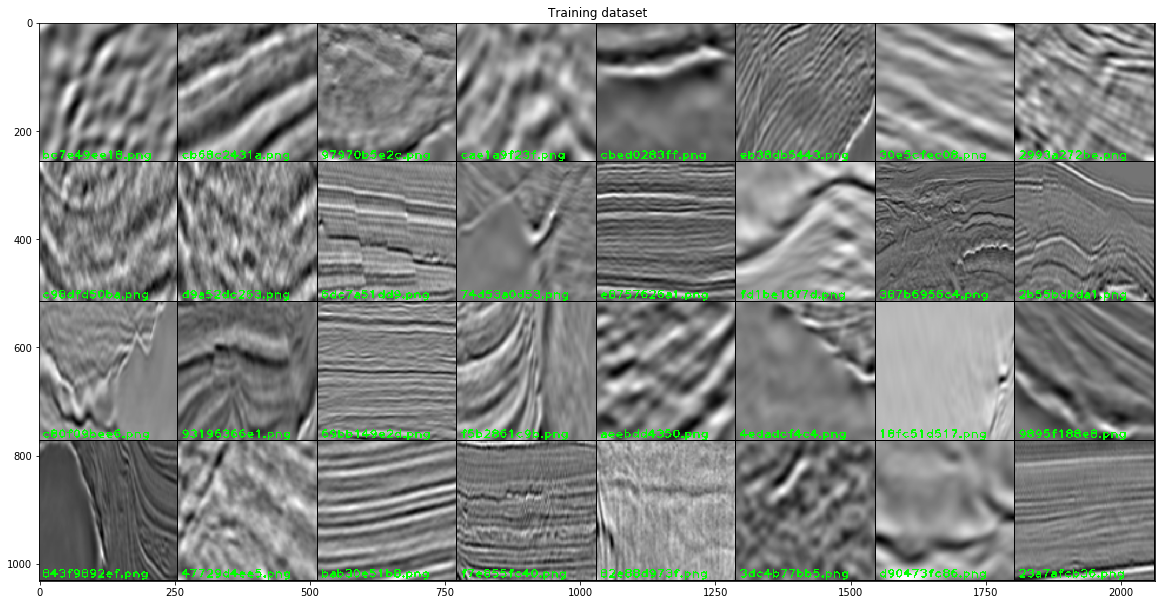

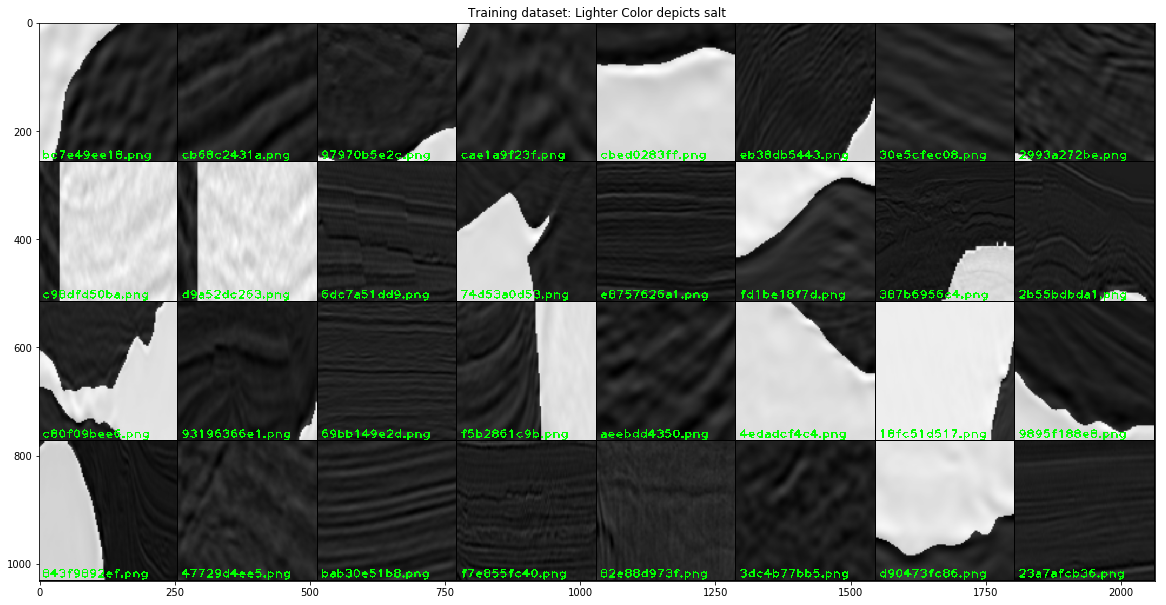

In [ ]:
foo = [val[:-4] for val in train_ids]
temp = df.set_index('id')
df_train = temp.loc[foo]
print('df_train shape:',df_train.shape[0])
df_train = df_train.reset_index()

foo = [val[:-4] for val in test_ids]
temp = df.set_index('id')
df_test = temp.loc[foo]
df_test = df_test.reset_index()

print('df_test shape:',df_test.shape[0])

In [ ]:
sns.distplot(df_train['z'],kde_kws={ "lw": 3, "label": "Train KDE"})
sns.distplot(df_test['z'],kde_kws={ "lw": 3, "label": "Test KDE"})
plt.title('Comparing Train and Test Set Depth Distributions')

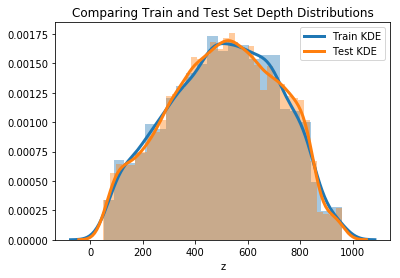

# Salt content and the depth

Let's try to see if there is any relationship between the salt content and the depth.

In [ ]:
df_train = df_train.set_index('id')
df_train['saltPercentage'] = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = path_train

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))

    df_train.loc[id_[:-4],'saltPercentage'] = np.sum(mask[:]>0)/(mask.shape[0]*mask.shape[1])
    
df_train = df_train.reset_index()

In [ ]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.distplot(df_train['saltPercentage'])
print("There are",np.sum(df_train['saltPercentage']>0.95),"images with salt content greater than 95%")

It seems that there is a corrleation of 0.1 between depth and saltPercentage. Let's dig deeper.

In [ ]:
df_train['bin'] = pd.cut(df_train.z,3)
# df_train['bin'] = pd.qcut(df_train.z,3)
depth_idx = []
unique_bins = np.unique(df_train.bin.values)
for bin_interval in unique_bins:
    depth_idx.append(np.ravel(np.where(df_train['bin']==bin_interval)))

In [ ]:
print(df_train.groupby('bin')['saltPercentage'].mean())
# sns.set_style("white")
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.regplot(x='z',y='saltPercentage', data=df_train)

In [ ]:
depth1 = df_train.groupby('bin')
depth1 = depth1.get_group(unique_bins[0])
depth2 = df_train.groupby('bin')
depth2 = depth2.get_group(unique_bins[1])
depth3 = df_train.groupby('bin')
depth3 = depth3.get_group(unique_bins[2])
print("Depth: {} to {}\n".format(unique_bins[0].left,unique_bins[0].right),depth1[['saltPercentage','z']].corr())
print("Depth: {} to {}\n".format(unique_bins[1].left,unique_bins[1].right),depth2[['saltPercentage','z']].corr())
print("Depth: {} to {}\n".format(unique_bins[2].left,unique_bins[2].right),depth3[['saltPercentage','z']].corr())

We can see the mean Salt Percentage is highest for the group of images at depth between 353 and 656..
We can further notice that correlation of Salt Percentage is high for depths between 50 and 353 which may mean that as we go deeper from 50 to 353, the salt content seems to increase... At deeper depths, the correlation seems to be negligible.

In [ ]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.distplot(depth1['saltPercentage'],hist=False,label="Depth: {} to {}".format(unique_bins[0].left,unique_bins[0].right))
sns.distplot(depth2['saltPercentage'],hist=False,label="Depth: {} to {}".format(unique_bins[1].left,unique_bins[1].right))
sns.distplot(depth3['saltPercentage'],hist=False,label="Depth: {} to {}".format(unique_bins[2].left,unique_bins[2].right))

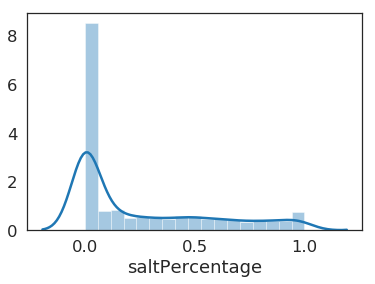

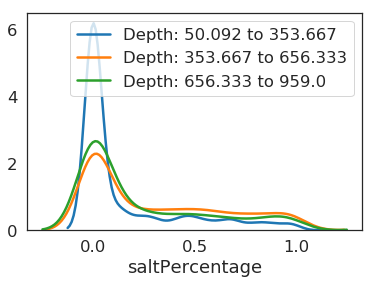

We can see from the above plot that depths between 50 and 353 has a high number of images with no salt contents.
It can also be observed that depths 353 to 656 has the highest salt content for Salt Percentage greater than 0.25.

<h2>**Plotting Images: Depthwise**

Let's plot some images at different depths and try to see if we are able to glean any differences. This way, we can get some sense of what we're looking at. The images are 101 x 101 pixels each with the mask (in lighter color) overlayed on top of it. 

In [ ]:
nImg = 32  #no. of images that you want to display
np.random.seed(42)
_train_ids = list(df_train.loc[depth_idx[0],'id']+'.png')
# _train_ids = list(train_ids)
np.random.shuffle(_train_ids)
_train_ids = _train_ids[:nImg]
tile_size = (256, 256)
n = 8

m = int(np.ceil(len(_train_ids) * 1.0 / n))
complete_image_masked = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i*(tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j*(tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids):
            break
        image_id = _train_ids[counter]; counter+=1
        img = get_image_data(image_id, 'Train')
        
        mask = get_image_data(image_id, "Train_mask")
        img_masked =  cv2.addWeighted(img, alpha, mask, 1 - alpha,0)
        img_masked = cv2.resize(img_masked, dsize=tile_size)
        
        
        img_masked = cv2.putText(img_masked, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), thickness=2)
        complete_image_masked[ys:ye, xs:xe, :] = img_masked[:,:,:]
        
    if counter == len(_train_ids):
        break    
m = complete_image_masked.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image_masked[ys:ye,:,:])
    plt.title("Training Set Depth Range: {} to {}".format(unique_bins[0].left,unique_bins[0].right))
#     plt.legend('Lighter Color depicts salt')

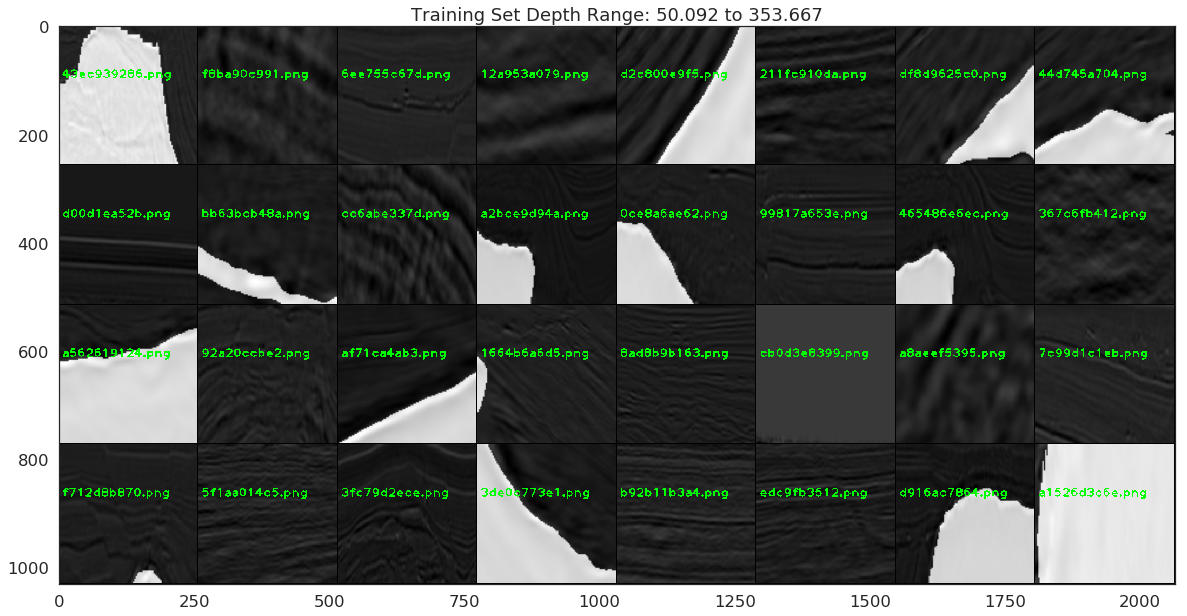

In [ ]:
nImg = 32  #no. of images that you want to display
np.random.seed(42)
_train_ids = list(df_train.loc[depth_idx[1],'id']+'.png')
# _train_ids = list(train_ids)
np.random.shuffle(_train_ids)
_train_ids = _train_ids[:nImg]
tile_size = (256, 256)
n = 8

m = int(np.ceil(len(_train_ids) * 1.0 / n))
complete_image_masked = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i*(tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j*(tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids):
            break
        image_id = _train_ids[counter]; counter+=1
        img = get_image_data(image_id, 'Train')
        
        mask = get_image_data(image_id, "Train_mask")
        img_masked =  cv2.addWeighted(img, alpha, mask, 1 - alpha,0)
        img_masked = cv2.resize(img_masked, dsize=tile_size)
        
        
        img_masked = cv2.putText(img_masked, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), thickness=2)
        complete_image_masked[ys:ye, xs:xe, :] = img_masked[:,:,:]
        
    if counter == len(_train_ids):
        break    
        
m = complete_image_masked.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image_masked[ys:ye,:,:])
    plt.title("Training Set Depth Range: {} to {}".format(unique_bins[1].left,unique_bins[1].right))
#     plt.legend('Lighter Color depicts salt')

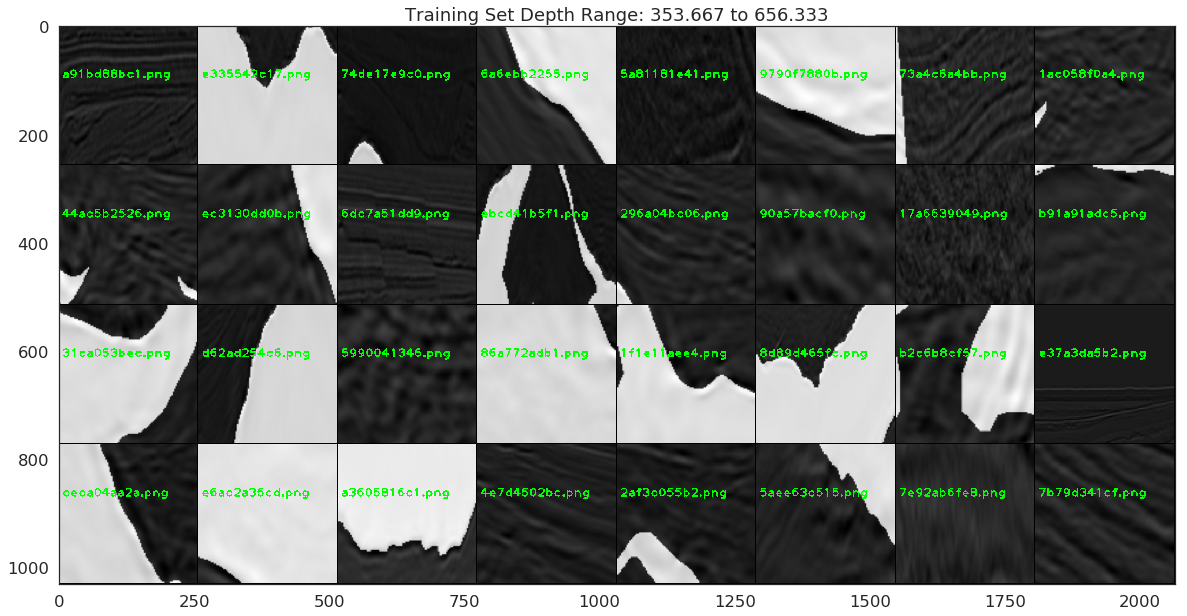

In [ ]:
nImg = 32  #no. of images that you want to display
np.random.seed(42)
_train_ids = list(df_train.loc[depth_idx[2],'id']+'.png')
# _train_ids = list(train_ids)
np.random.shuffle(_train_ids)
_train_ids = _train_ids[:nImg]
tile_size = (256, 256)
n = 8

m = int(np.ceil(len(_train_ids) * 1.0 / n))
complete_image_masked = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i*(tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j*(tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids):
            break
        image_id = _train_ids[counter]; counter+=1
        img = get_image_data(image_id, 'Train')
#         segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
# #         segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
# #         segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
#         img = mark_boundaries(img, segments_fz)
# #         thresh =  threshold_sauvola(img)
# #         img = img < thresh
#         img = (img*255).astype('uint8')
        img = cv2.resize(img, dsize=tile_size)
        
        mask = get_image_data(image_id, "Train_mask")
        mask = cv2.resize(mask, dsize=tile_size)
        img_masked =  cv2.addWeighted(img, alpha, mask, 1 - alpha,0)
        img_masked = cv2.resize(img_masked, dsize=tile_size)
        
        
#         img_masked = cv2.putText(img_masked, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), thickness=2)
        complete_image_masked[ys:ye, xs:xe, :] = img_masked[:,:,:]
        
    if counter == len(_train_ids):
        break    
        
m = complete_image_masked.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image_masked[ys:ye,:,:])
    plt.title("Training Set Depth Range: {} to {}".format(unique_bins[2].left,unique_bins[2].right))
#     plt.legend('Lighter Color depicts salt')

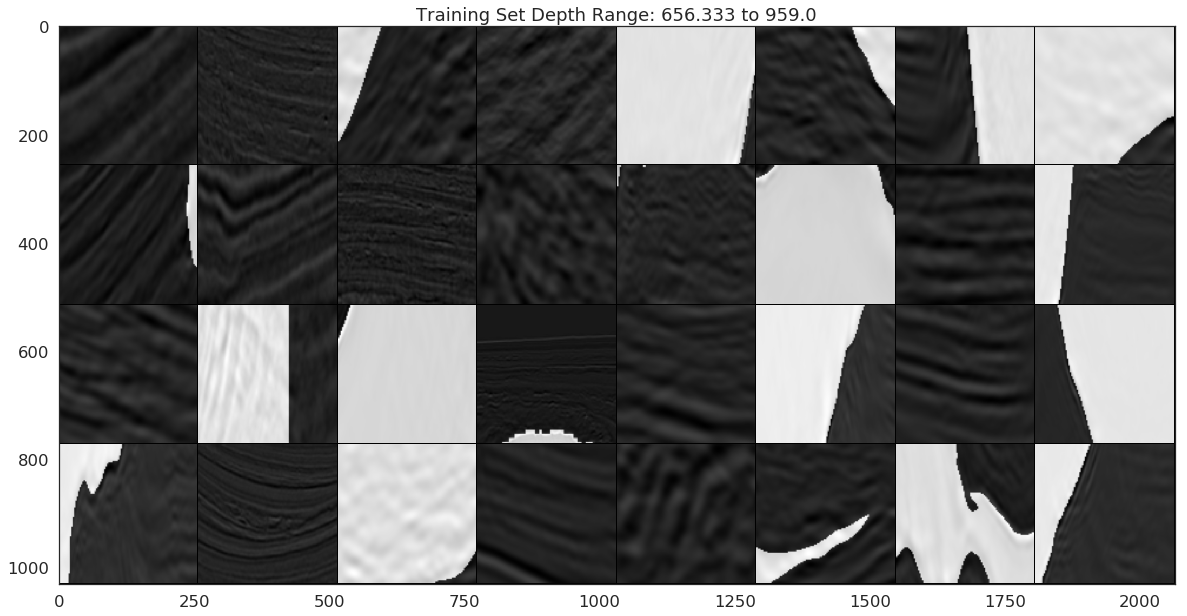

It seems that at depth 0 i.e. 50 to 353 the masks appear to be in the lower part of the image. Similarly at depth 2 i.e. 656 to 959 the masks appear to be in the lower part of the image. Let's try to confirm our suspicions  by plotting the mean location of masks at different depths.

<h2> Visualizing the masks

In [ ]:
_train_ids = list(df_train.loc[depth_idx[0],'id']+'.png')
mask_depth0 = np.zeros((101, 101,len(_train_ids)), dtype=np.float32)
for n, id_ in tqdm(enumerate(_train_ids), total=len(_train_ids)):
    image_id = _train_ids[n]
    mask = get_image_data(image_id, "Train_mask")
    mask_depth0[:,:,n] = (mask[:,:,0]>0).astype('uint8')

mean_mask_depth0 = mask_depth0.mean(axis=2)

_train_ids = list(df_train.loc[depth_idx[1],'id']+'.png')
mask_depth1 = np.zeros((101, 101,len(_train_ids)), dtype=np.float32)
for n, id_ in tqdm(enumerate(_train_ids), total=len(_train_ids)):
    image_id = _train_ids[n]
    mask = get_image_data(image_id, "Train_mask")
    mask_depth1[:,:,n] = (mask[:,:,0]>0).astype('uint8')

mean_mask_depth1 = mask_depth1.mean(axis=2)

_train_ids = list(df_train.loc[depth_idx[2],'id']+'.png')
mask_depth2 = np.zeros((101, 101,len(_train_ids)), dtype=np.float32)
for n, id_ in tqdm(enumerate(_train_ids), total=len(_train_ids)):
    image_id = _train_ids[n]
    mask = get_image_data(image_id, "Train_mask")
    mask_depth2[:,:,n] = (mask[:,:,0]>0).astype('uint8')

mean_mask_depth2 = mask_depth2.mean(axis=2)

In [ ]:
fig = plt.figure(1,figsize=(30,15))
ax = fig.add_subplot(1,3,1)
ax.imshow(mean_mask_depth0)
ax.set_title("Depth Range: {} to {}".format(unique_bins[0].left,unique_bins[0].right))

ax = fig.add_subplot(1,3,2)
ax.imshow(mean_mask_depth1)
ax.set_title("Depth Range: {} to {}".format(unique_bins[1].left,unique_bins[1].right))

ax = fig.add_subplot(1,3,3)
ax.imshow(mean_mask_depth2)
ax.set_title("Depth Range: {} to {}".format(unique_bins[2].left,unique_bins[2].right))

plt.suptitle('Mean Masks at different depths',y=0.8)

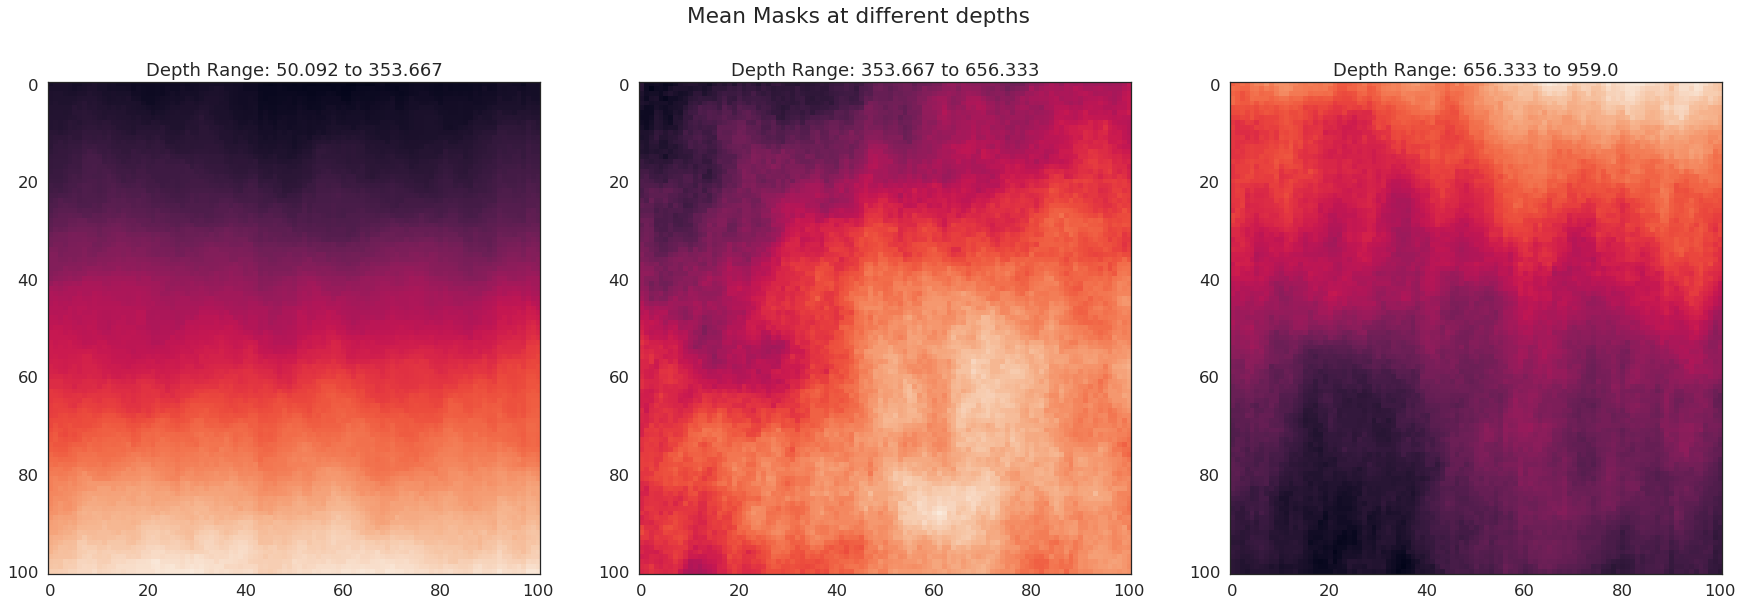

This helps to confirm our suspicion that salt is not equally distributed at all depths. 

**<h2>Transforming the Images**

Let's try to transform the images in some way to enhance the contrast between the salt and the background.

In [ ]:
# defining the kernels
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

<h3>**Smoothing the Image**

In [ ]:
_train_ids = list(df_train.loc[depth_idx[2],'id']+'.png')
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    image_id = _train_ids[i]
    ax = fig.add_subplot(3,3,i+1)
    img = get_image_data(image_id, 'Train')
    img = signal.convolve2d(img[:,:,0],smooth,mode='valid')
    img = img.astype('uint8')
    img = cv2.resize(img, dsize=tile_size)
    mask = get_image_data(image_id, "Train_mask")
    mask = cv2.resize(mask, dsize=tile_size)
    mask = mask[:,:,0]
    img_masked =  cv2.addWeighted(img, alpha, mask, 1 - alpha,0)
    img_masked = cv2.resize(img_masked, dsize=tile_size)
    ax.imshow(img_masked,cmap='binary')
    ax.set_title('Smoothed Image')
    
plt.show()
plt.suptitle('Smoothed Image with Mask overlayed')

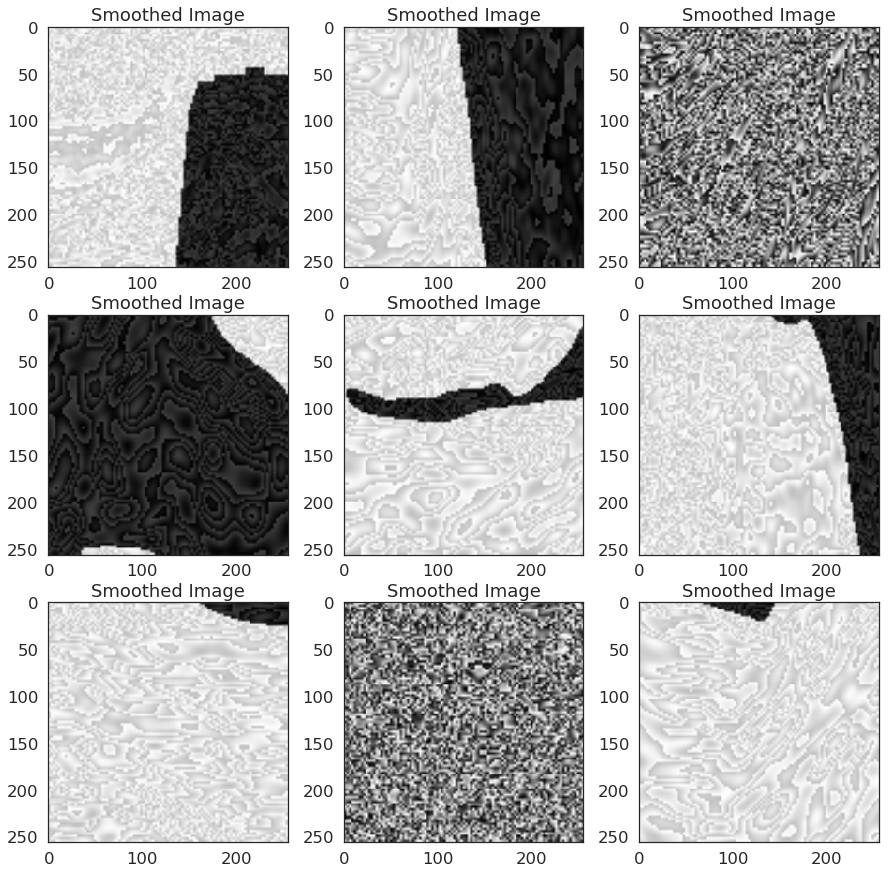

As we might expect, smoothing blurs the features. However, it also enhances the contrast between bright and dark regions, so it may be quite useful if we want to use it to seed some clusters..

<h3>**First Derivatives**

Let's try to take X-Derivative and  Y-Derivative of the image. We can also take alook at the magnitude of the gradient which can be calculated by taking  the x and y derivatives as a gradient vector at each position and then taking the magnitude at each point.

In [ ]:
# Plot band_1
_train_ids = list(df_train.loc[depth_idx[2],'id']+'.png')
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
q = 0
for i in range(3):
    q = q+1
    image_id = _train_ids[i]
#     ax = fig.add_subplot(3,3,i+1)
    img = get_image_data(image_id, 'Train')
    img_orig = img.copy()
    
    img_x = signal.convolve2d(img[:,:,0],xder,mode='valid')
    img_x = img_x.astype('uint8')
    img_x = cv2.resize(img_x, dsize=tile_size)
    
    img_y = signal.convolve2d(img[:,:,0],yder,mode='valid')
    img_y = img_y.astype('uint8')
    img_y = cv2.resize(img_y, dsize=tile_size)
    
    grad_img = np.hypot(img_x,img_y)
    grad_img = grad_img.astype('uint8')
    grad_img = cv2.resize(grad_img, dsize=tile_size)
    
    mask = get_image_data(image_id, "Train_mask")
    mask = cv2.resize(mask, dsize=tile_size)
    mask = mask[:,:,0]
    
    plt.subplot(3,6,q*6-5)
    plt.imshow(img_orig, cmap='binary')
    plt.title('Original Image')
    
    plt.subplot(3,6,q*6-4)
    plt.imshow(mask, cmap='binary')
    plt.title('Image Mask')
    
    plt.subplot(3,6,q*6-3)    
    plt.imshow(img_x, cmap='binary')
    plt.title('X-Derivative')
    
    plt.subplot(3,6,q*6-2)    
    plt.imshow(img_y, cmap='binary')
    plt.title('Y-Derivative')
    
    plt.subplot(3,6,q*6-1)    
    plt.imshow(grad_img,cmap='binary')
    plt.title('Gradient Magnitude')
    
plt.show()
plt.suptitle('Visualizing First Derivatives', y=0.75, fontsize=30)

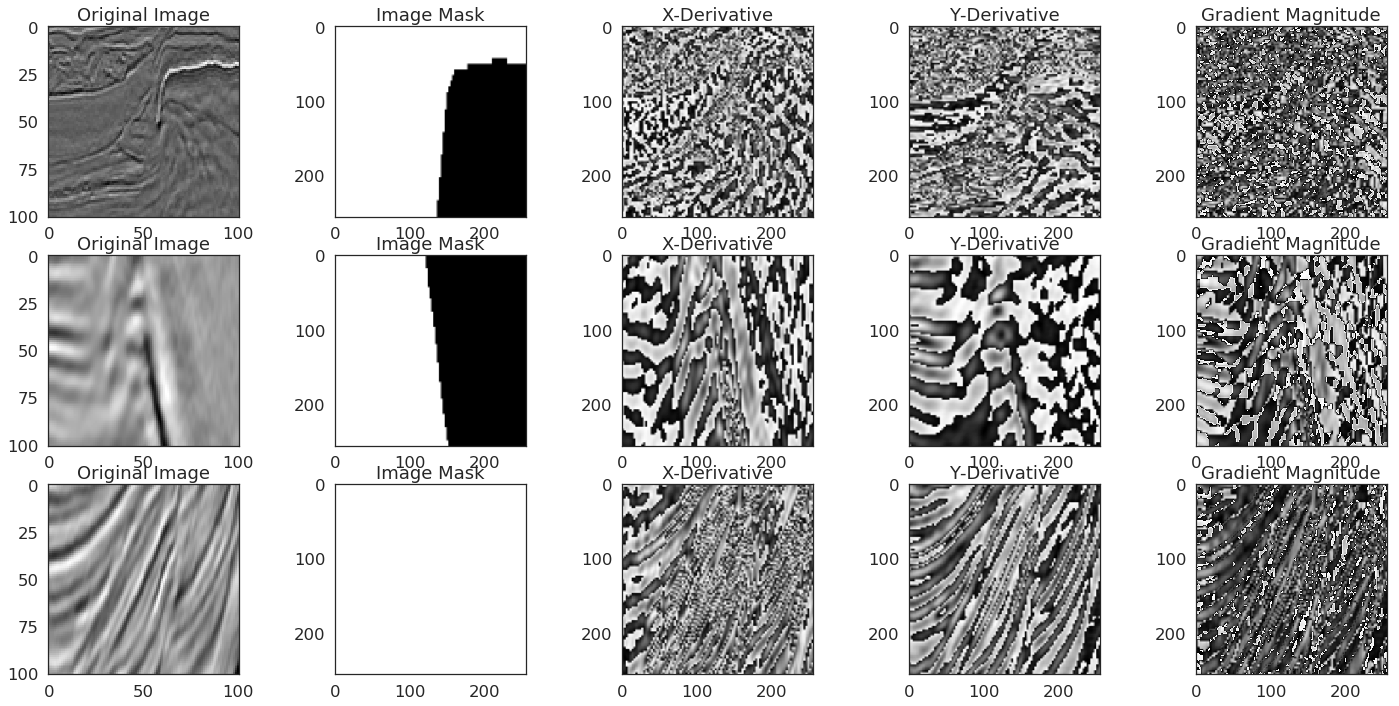

It can be seen that Y-derivative has some interesting pattern. We could perhaps use it in our cnn.

<h3>**Second Derivatives**

We can also define a simple second-derivative operator. The  second order derivatives should do less smoothing than a first order derivative, so we might see less contrast between the salt and the background.
The Laplacian operator is just the sum of second derivatives, or the divergence of the gradient.

In [ ]:
# Plot band_1
_train_ids = list(df_train.loc[depth_idx[2],'id']+'.png')
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
q = 0
for i in range(3):
    q = q+1
    image_id = _train_ids[i]
#     ax = fig.add_subplot(3,3,i+1)
    img = get_image_data(image_id, 'Train')
    img_orig = img.copy()
    
    img_x = signal.convolve2d(img[:,:,0],xder2,mode='valid')
    img_x = img_x.astype('uint8')
    img_x = cv2.resize(img_x, dsize=tile_size)
    
    img_y = signal.convolve2d(img[:,:,0],yder2,mode='valid')
    img_y = img_y.astype('uint8')
    img_y = cv2.resize(img_y, dsize=tile_size)
    
    laplacian = np.hypot(img_x,img_y)
    laplacian = laplacian.astype('uint8')
    laplacian = cv2.resize(laplacian, dsize=tile_size)
    
    mask = get_image_data(image_id, "Train_mask")
    mask = cv2.resize(mask, dsize=tile_size)
    mask = mask[:,:,0]
    
    plt.subplot(3,6,q*6-5)
    plt.imshow(img_orig, cmap='binary')
    plt.title('Original Image')
    
    plt.subplot(3,6,q*6-4)
    plt.imshow(mask, cmap='binary')
    plt.title('Image Mask')
    
    plt.subplot(3,6,q*6-3)    
    plt.imshow(img_x, cmap='binary')
    plt.title('Second X-Derivative')
    
    plt.subplot(3,6,q*6-2)    
    plt.imshow(img_y, cmap='binary')
    plt.title('Second Y-Derivative')
    
    plt.subplot(3,6,q*6-1)    
    plt.imshow(laplacian,cmap='binary')
    plt.title('Laplacian')
    
plt.show()
plt.suptitle('Visualizing Second Derivatives')

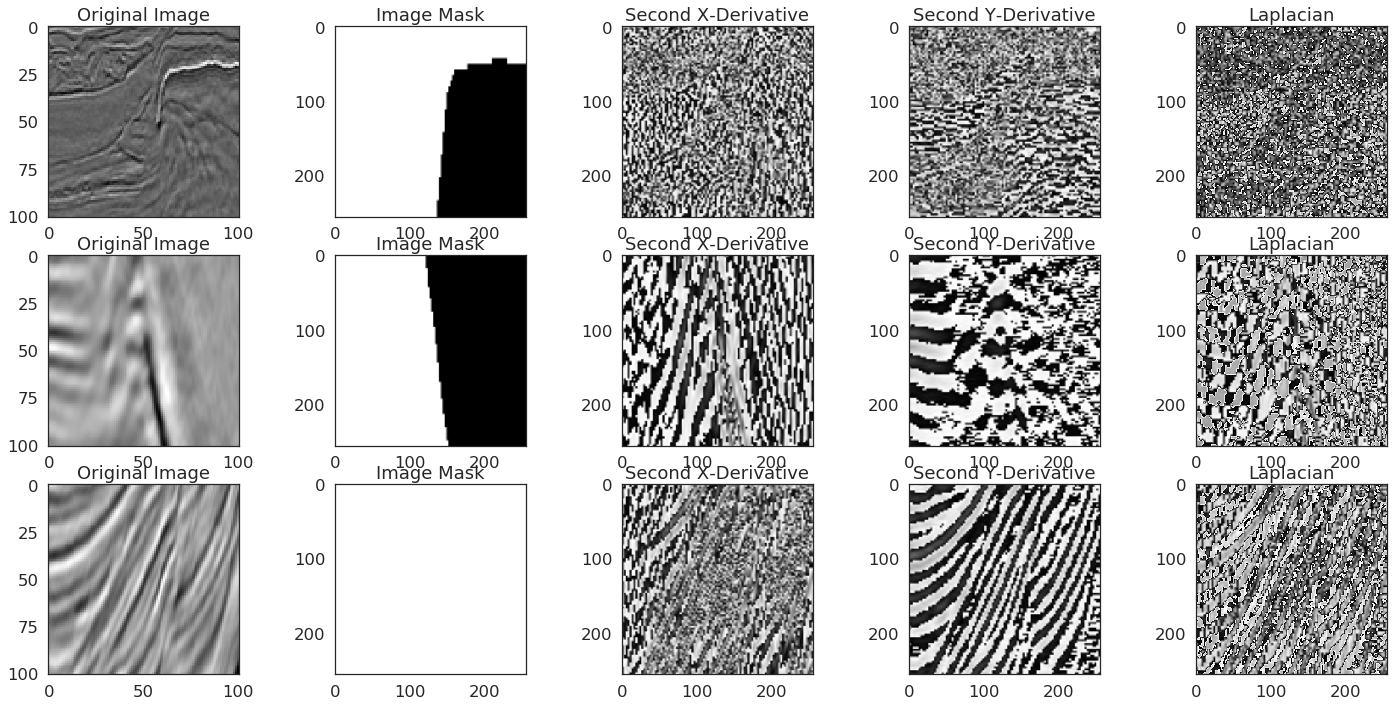

We've looked at a number of transformations of the images. Gradient-based methods can be used to get features, and smoothing may help out with images with small regions of salt.